In [1]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
 
%cd ../..

/private/home/pfz/09-videoseal/videoseal-dev


In [27]:
from videoseal.utils.display import save_img
from videoseal.utils import Timer
from videoseal.evals.full import setup_model_from_checkpoint
from videoseal.evals.metrics import bit_accuracy, psnr, ssim
from videoseal.augmentation import Identity, JPEG
from videoseal.modules.jnd import JND, VarianceBasedJND

import os
import omegaconf
from tqdm import tqdm
import gc
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision

to_tensor = torchvision.transforms.ToTensor()
to_pil = torchvision.transforms.ToPILImage()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = "cpu" 
# Directory containing videos
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Create ckpt.
ckpt = "/checkpoint/pfz/2025_logs/0318_vseal_advtrain_morelr/_adv_max_lr=100.0_adv_min_lr=1e2_adv_perturbation=1.0/checkpoint250.pth"
wam = setup_model_from_checkpoint(ckpt)
wam.eval()
wam.to(device)
wam.blender.scaling_w = 0.2

# Iterate over all video files in the directory
num_imgs = 16
assets_dir = "/large_experiments/omniseal/sa-1b/val"
files = [f for f in os.listdir(assets_dir) if f.endswith(".png") or f.endswith(".jpg")]
files = [os.path.join(assets_dir, f) for f in files]
files = files[:num_imgs]
imgs = [Image.open(file, "r").convert("RGB") for file in files]
imgs = [img.resize((512, 512), Image.LANCZOS) for img in imgs]
imgs = torch.stack([to_tensor(img) for img in imgs], dim=0)  # b c h w
imgs = imgs.to(device)

Model loaded successfully from /checkpoint/pfz/2025_logs/0318_vseal_advtrain_morelr/_adv_max_lr=100.0_adv_min_lr=1e2_adv_perturbation=1.0/checkpoint250.pth with message: <All keys matched successfully>


In [35]:
# Initialize delta with zeros (same shape as imgs)
delta = torch.zeros_like(imgs, requires_grad=True, device=device)

# Set the optimizer to optimize delta instead of batch_imgs
optimizer = torch.optim.Adam([delta], lr=0.1)
loss_fn = torch.nn.MSELoss()
num_iterations = 10

# Select random vector.
random_vector = torch.randn(129, device=device)

# Do the optimization.
for i in range(num_iterations):
    optimizer.zero_grad()
    # Apply delta to get batch_imgs
    batch_imgs = imgs + 0.05 * torch.nn.functional.tanh(delta)
    preds = wam.detector(batch_imgs)
    loss = loss_fn(preds, random_vector)
    loss.backward()
    optimizer.step()
    print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item()}")

# Final batch_imgs is imgs + delta
batch_imgs = (imgs + 0.1 * torch.nn.functional.tanh(delta)).clamp(0, 1)

/private/home/pfz/miniconda3/envs/img/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([129])) that is different to the input size (torch.Size([16, 129])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 1/10, Loss: 0.936827540397644
Iteration 2/10, Loss: 0.8864060044288635
Iteration 3/10, Loss: 0.762515664100647
Iteration 4/10, Loss: 0.5500935316085815
Iteration 5/10, Loss: 0.4386211633682251
Iteration 6/10, Loss: 0.3071442246437073
Iteration 7/10, Loss: 0.20606888830661774
Iteration 8/10, Loss: 0.14811934530735016
Iteration 9/10, Loss: 0.11280272156000137
Iteration 10/10, Loss: 0.09297823160886765


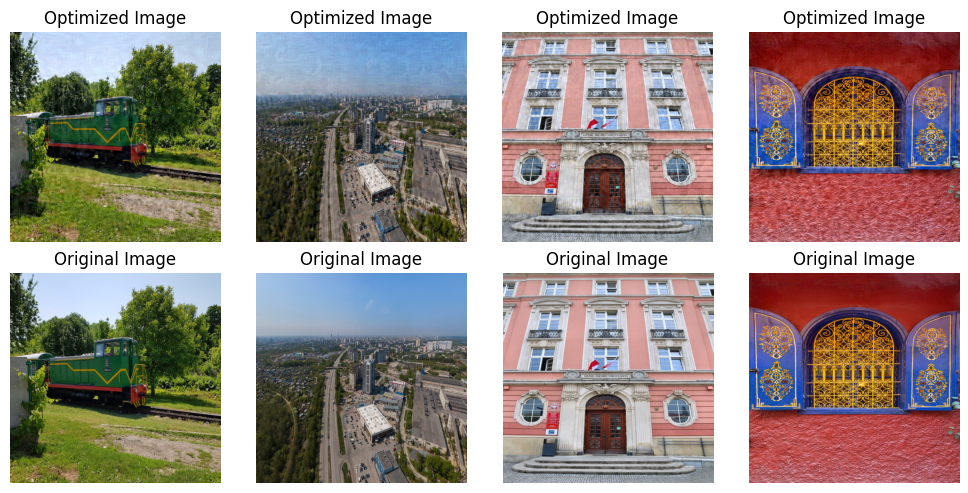

In [37]:
# show the image original image and the optimized image.
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(to_pil(batch_imgs[i].cpu()))
    plt.axis("off")
    plt.title("Optimized Image")
    plt.subplot(2, 4, i + 5)
    plt.imshow(to_pil(imgs[i].cpu()))
    plt.axis("off")
    plt.title("Original Image")
plt.tight_layout()
plt.show()